In [1]:
data_dir = "~/var/aml-xrays"
coco_json_name = "cxr_covid_coco.json"

In [123]:
import pydicom
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
# requires: GDCM, pylibjpeg, pylibjpeg-libjpeg for decoding compressed images

In [3]:
data_path = Path(data_dir).expanduser()

## CSVs
### Image Level Train CSV

In [4]:
image_level = pd.read_csv(data_path / "train_image_level.csv")
image_level

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


### Study Level Train CSV

In [5]:
study_level = pd.read_csv(data_path / "train_study_level.csv")
study_level

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


### Sample Submission

In [6]:
sample_sub = pd.read_csv(data_path / "sample_submission.csv")
sample_sub

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1


In [7]:
def resolve_image_paths(study_id, dataset="train"):
    study_path = data_path / dataset / study_id
    image_paths = []
    for series_path in study_path.iterdir():
        if series_path.is_dir():
            [image_paths.append(image_path) for image_path in series_path.iterdir()]
    return image_paths

def study_id_from_csv_id(csv_id):
    return csv_id[:-6]

def csv_id_to_paths(csv_id, dataset="train"):
    return resolve_image_paths(study_id_from_csv_id(csv_id), dataset)

In [8]:
csv_id_to_paths("00086460a852_study")

[PosixPath('/home/tkrieger/var/aml-xrays/train/00086460a852/9e8302230c91/65761e66de9f.dcm')]

In [9]:
typical = study_level[study_level["Typical Appearance"] == 1]

In [10]:
sample_csv_id = typical.head(1)["id"].values[0]
dicom_obj = pydicom.dcmread(csv_id_to_paths(sample_csv_id)[0])

In [11]:
dicom_obj

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.59189821846420219299438915042640676800
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 65761e66de9f
(0008, 0020) Study Date                          DA: '4545ba78b753'
(0008, 0030) Study Time                          TM: 'bf1677526b2b'
(0008, 0050) Accession Number                    SH: '5f20f119e3df'
(0008, 0060) Modality                            CS: 'DX'
(0009, 0010) Private Creator                     LO: 'GEIIS'
(0010

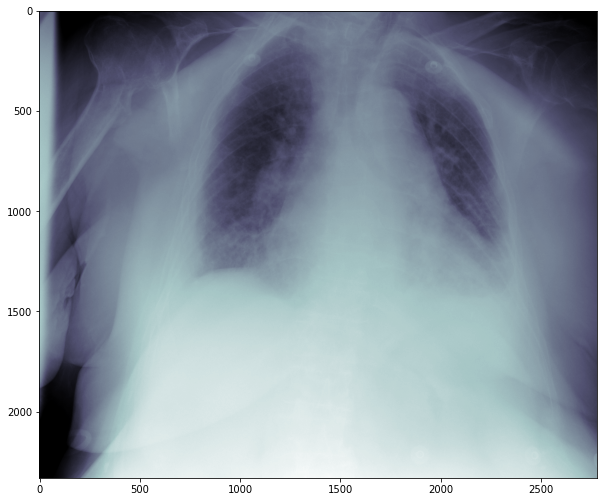

In [12]:
plt.figure(figsize=(10,20))
plt.imshow(dicom_obj.pixel_array, cmap=plt.cm.bone)

In [13]:
study_level.loc[:, study_level.columns != "id"].sum(axis=1).unique()

array([1])

In [153]:
def show_dcm(dcm, ax):
    img_data = dcm.pixel_array
    img_data = pydicom.pixel_data_handlers.util.apply_voi_lut(img_data, dcm)
    if dcm.PhotometricInterpretation == "MONOCHROME1":
        img_data = np.amax(img_data) - img_data
    ax.imshow(img_data, cmap=plt.cm.bone)
    
def add_bounding_boxes(dcm, ax):
    instance_uid = dcm.SOPInstanceUID
    box_str = image_level[image_level["id"] == instance_uid + "_image"]["boxes"].iloc[0]
    if (not pd.isnull(box_str)):
        boxes = ast.literal_eval(box_str)
        if (isinstance(boxes, list)):
            for box in boxes:
                mp_box = patches.Rectangle((box['x'], box['y']), box['width'], box['height'], edgecolor="r", facecolor='none')
                ax.add_patch(mp_box)

def show_samples_for(prediction, number_of_samples=3):
    samples = study_level[study_level[prediction] == 1].sample(number_of_samples)
    study_paths_iter = map(csv_id_to_paths, samples["id"])
    for i, study_paths in enumerate(study_paths_iter):
        fig, axs = plt.subplots(1, len(study_paths), figsize=(10,8))
        fig.suptitle(f'Study: {samples["id"].iloc[i]}')
        for im_i, image_path in enumerate(study_paths):
            ax = axs[im_i] if isinstance(axs, np.ndarray) else axs
            ax.set_title(f'Instance / Image Nr. {im_i + 1} / {len(study_paths)}')
            dcm = pydicom.dcmread(image_path)
            plt.figure()
            show_dcm(dcm, ax)
            add_bounding_boxes(dcm, ax)

## Samples: Negative

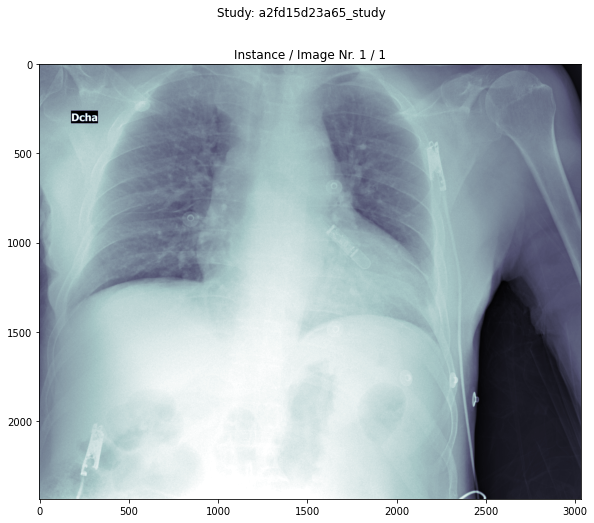

<Figure size 432x288 with 0 Axes>

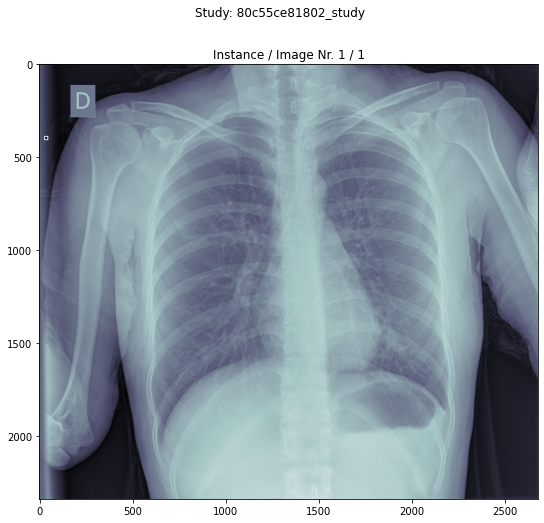

<Figure size 432x288 with 0 Axes>

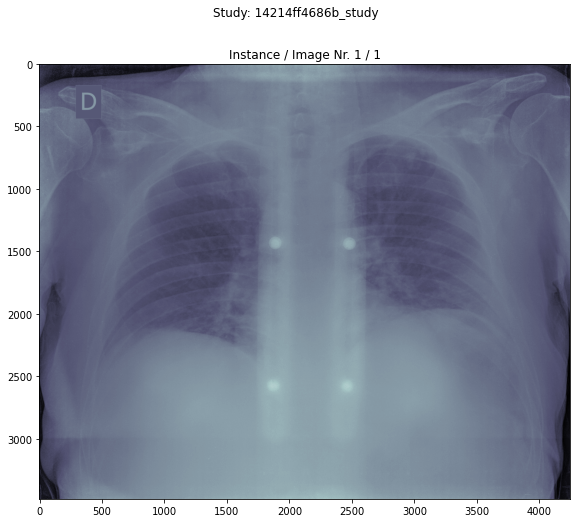

<Figure size 432x288 with 0 Axes>

In [154]:
show_samples_for("Negative for Pneumonia")

## Samples: Typical Appearance

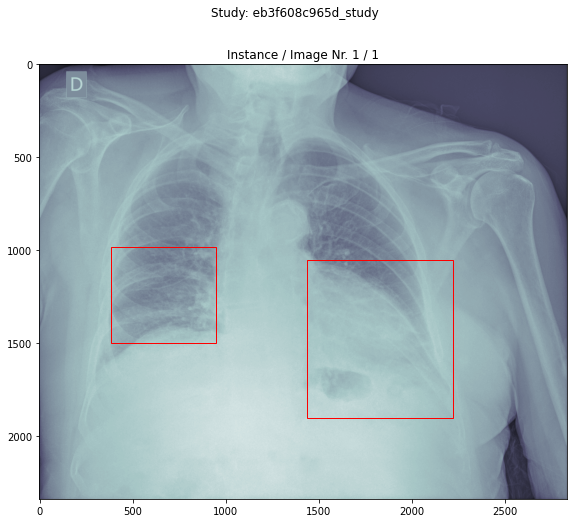

<Figure size 432x288 with 0 Axes>

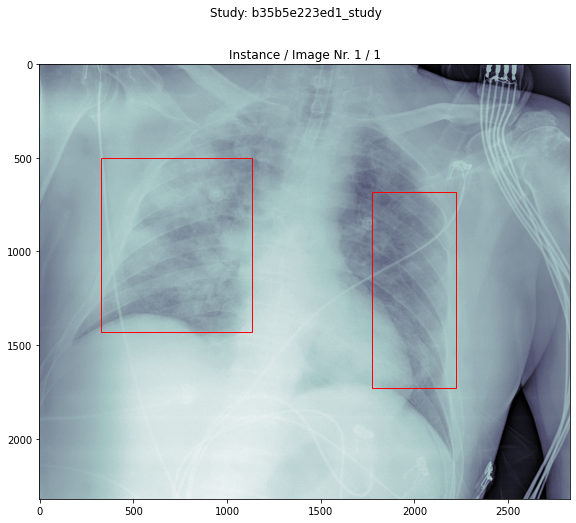

<Figure size 432x288 with 0 Axes>

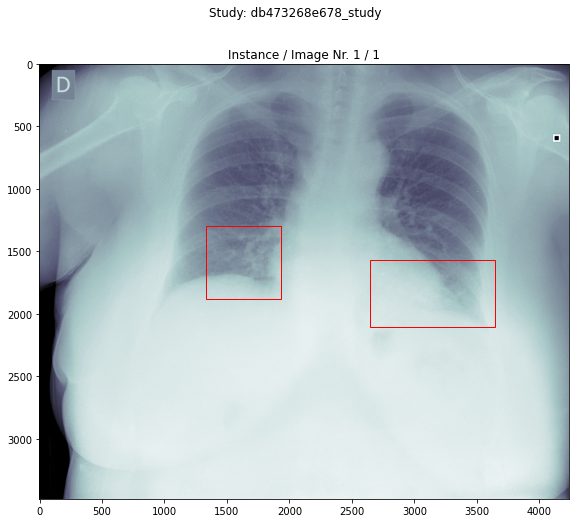

<Figure size 432x288 with 0 Axes>

In [150]:
show_samples_for("Typical Appearance")

## Samples: Indeterminate Appearance

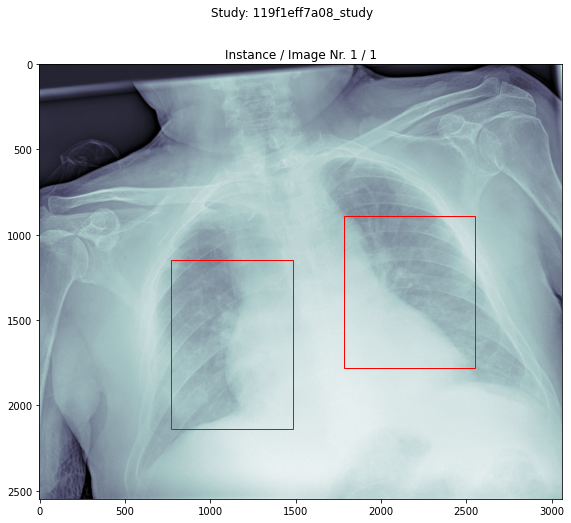

<Figure size 432x288 with 0 Axes>

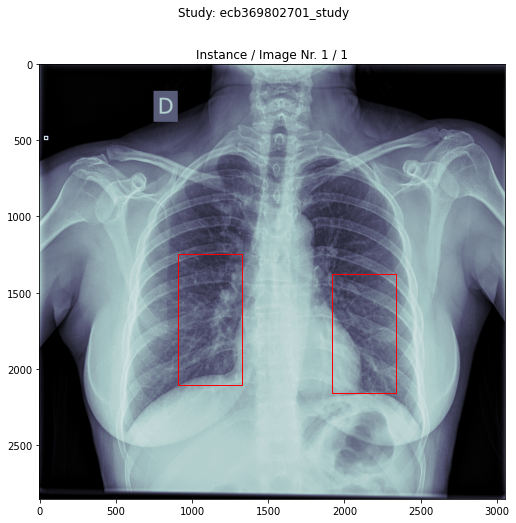

<Figure size 432x288 with 0 Axes>

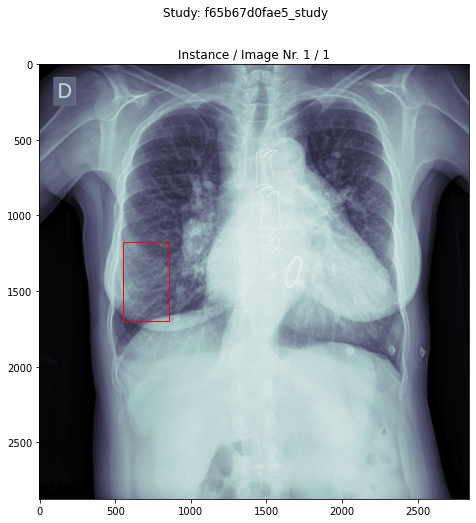

<Figure size 432x288 with 0 Axes>

In [151]:
show_samples_for("Indeterminate Appearance")

## Samples: Atypical Appearance

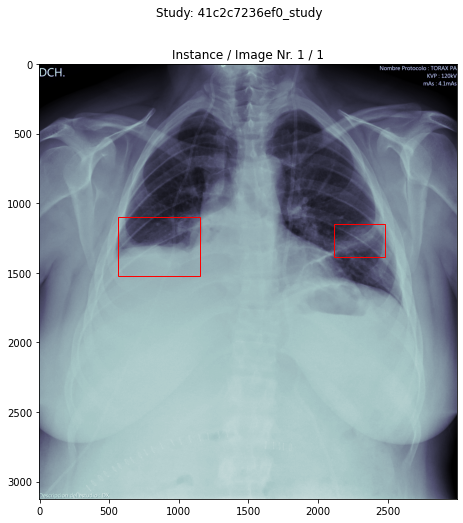

<Figure size 432x288 with 0 Axes>

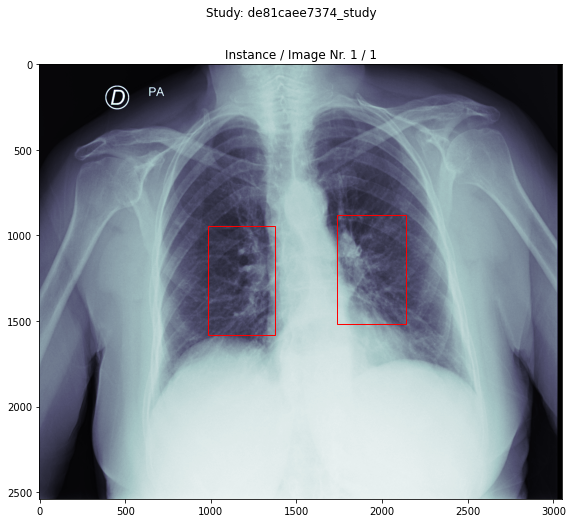

<Figure size 432x288 with 0 Axes>

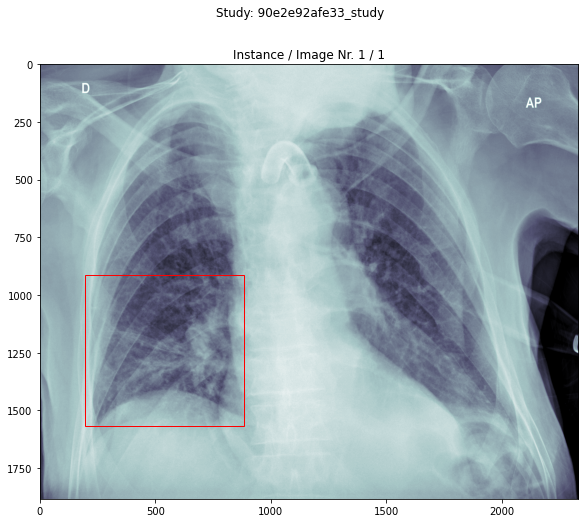

<Figure size 432x288 with 0 Axes>

In [152]:
show_samples_for("Atypical Appearance")

## Create COCO JSON

In [2]:
from cxrcoco import CxrCOCO

cxr_coco = CxrCOCO(data_dir)
cxr_coco.to_json_file(coco_json_name)

Processing dicom files and extract COCO format:



100%|██████████| 6334/6334 [01:18<00:00, 80.89it/s] 


Writing result to file: /home/tkrieger/var/aml-xrays/cxr_covid_coco.json
